In [1]:
import pandas as pd
import scipy as sp
from scipy.sparse import diags
import numpy as np
from numpy import linalg as LA
import sys
from os import path

import matplotlib.pyplot as plt

#importing seaborn for plotting
import seaborn as sns

#for plotting purposes
%pylab inline
sns.set_style('ticks')
sns.set_context('paper')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib as mpl

# mpl.rcParams
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = [8, 16/3]

Populating the interactive namespace from numpy and matplotlib


## functions for use in processing

In [2]:
#porting from HITRACE
#based on Baseline correction for NMR spectroscopic metabolomics data analysis. 2008, 
#Author(s): Xi, Yuanxin and Rocke, David M
#https://doi.org/10.1186/1471-2105-9-324 and further modified by Rhiju (Stanford University)
#name of variables tracks closely to what is presented in the manuscript

def baseline_xi(b,A=2e9,B=2e4,s=1.0):
    # Input: 
    # b Nx1, spectrum data
    # A 1x1 smoothing factor
    # B 1x1 negative penalty
    # s 1x1 noise standard deviation

    # Output:
    # bd Nx1 baseline
    # b_subtract Nx1 background subtracted trace

    L = len(b)

    # b is the SIGNAL (gamma in the paper). bd is the estimated baseline (b in the paper).
    bd = np.ones((L,1))*np.median(b)
    bd0 = b

    #current error
    nm = LA.norm(b-bd0)
    nm0 = sys.float_info.max #initialize with largest possible float

    #solving D*bd = m
    #D and m have been divided through by A
    #Mistake in expression for M; should be +1, not -1
    M0 = s*np.ones((L,1))/A

    #initialize D matrix
    e = np.ones((L,1))
    diagonals = [2, -8, 12, -8, 2]
    D0 = diags(diagonals, np.arange(-2,3), shape=(L,L)).toarray()
    
    D0[0,0] = 2
    D0[L-1,L-1] = 2

    D0[1,0] = -4
    D0[0,1] = -4
    D0[L-1,L-2] = -4
    D0[L-2,L-1]= -4

    D0[1,1] = 10
    D0[L-2,L-2] = 10

    #index for iteration
    i=0

    while ((nm>10 or i<5) and i<30):
        i=i+1
        M = M0
        D = D0
        bd0 = bd
        nm0=nm #not sure this is needed, nm0 not used in iteration

        for j in np.arange(0,L):
            if (bd[j]>b[j]):
                M[j] = M[j] + 2*(B/A)*b[j]
                D[j,j] = D[j,j] + 2*(B/A)

        bd = solve(D,M).flatten() #need to flatten to convert to 1D array
        nm = LA.norm(bd0-bd)
    
    b_subtract = b-bd
    return b_subtract,bd

#### functions for finding peaks and calculating areas

In [3]:
from scipy.signal import find_peaks

###returns indices for peaks for a given trace as well as the values at the peaks
def find_trace_peaks(trace, min_distance=100, min_height=2.5):
    
    peak_idx, _ = find_peaks(trace, distance=min_distance, height=min_height)  
    peak_val = trace[peak_idx]

    return peak_idx, peak_val

In [4]:
def return_peak_areas(start_nt, end_nt, trace, trace_nt, ctrl_start=200, ctrl_end = 300):
    #start_nt and end_nt should flank the peak of interest
    #trace refers to the reading values (FU on the Bioanalyzer)
    #trace_nt refers to the x-axis, or the nucleotides corresponding to different values in trace
    #ctrl_start, and ctrl_end refer to P4P6 control, and is flanking a wider nucleotide window to account for accumulation
    #of background, degraded RNAs
    
    #indices for P4P6
    p4p6_start_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-ctrl_start))
    p4p6_end_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-ctrl_end))

    #indices for mRNA
    first_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-start_nt))
    last_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-end_nt)) 
    
    #calculating areas
    p4p6_area = np.trapz(y=trace[p4p6_start_idx:p4p6_end_idx], x=nts[p4p6_start_idx:p4p6_end_idx])
    background_area = np.trapz(y=[trace[first_idx], trace[last_idx]], x=[nts[first_idx],nts[last_idx]])
    total_area = np.trapz(y=trace[first_idx:last_idx], x=nts[first_idx:last_idx])
    
    subtracted_area = total_area-background_area
    normalized_area = subtracted_area/p4p6_area
    
    return p4p6_area, background_area, total_area, subtracted_area, normalized_area


def calc_frac_intact(times, norm_areas):
    
    init_val = float(norm_areas[0])
    frac_intact = (norm_areas/init_val).clip(0)
    
    return frac_intact

In [30]:
from scipy.optimize import curve_fit

#returns indices, bootstrapped
def bootstrap_inds(x):
    bs_indices = np.random.choice(range(len(x)),len(x))
    return bs_indices

#function for exponential fitting
def func(x, b):
    return np.exp(-b*x)


def exp_fit(frac_intact, timepoints, func, bs_iter = 1000):
    fit_coeffs = []
    for i in np.arange(0,bs_iter,1):
        
        #just in case
        frac_intact = np.clip(a=frac_intact, a_min=0, a_max=max(frac_intact))
        
        #generate bootstrap indices
        bs_indices = bootstrap_inds(frac_intact)
        
        #generating data for fit
        fit_t = [timepoints[i] for i in bs_indices]
        fit_fracint = [frac_intact[i] for i in bs_indices]
        
        #exponential fit
        popt, pcov = curve_fit(func, fit_t, fit_fracint)
        
        fit_coeffs.append(popt[0])
    
    return fit_coeffs

def log_transform_fit(timepoints, frac_intact, bs_iter=1000):
    
    fit_coeffs = []
    
    for i in np.arange(0,bs_iter, 1):
        frac_intact = np.absolute(frac_intact)
        
        #generate bootstrap indices
        bs_indices = bootstrap_inds(frac_intact)

        if (len(set(bs_indices))==1):
            continue
        
        #generating data for fit
        fit_t = [timepoints[i] for i in bs_indices]
        fit_fracint = [frac_intact[i] for i in bs_indices]
        
        #doing a first order fit after log transform
        fit = np.polyfit(fit_t, -1*np.log(fit_fracint), 1, w=np.sqrt(fit_fracint))
#         fit = np.polyfit(fit_t, -1*np.log(fit_fracint), 1)
        
        fit_coeffs.append(fit[0])
    
    return fit_coeffs

# Analysis of samples starts here:

### appending file names from each sample

In [6]:
### read in sample map
map_df = pd.read_csv('sample_nucleotide_filename.csv')
# map_df

#match plate number to filename:
filenames_df = pd.read_csv('platenumber_filename.csv')
# filenames_df
filenames_dict = dict(zip(filenames_df['Plate_Number'],filenames_df['File_Name']))
# filenames_dict

data_dir = './processed_data/'
#mapping plate number to filename, adding column to map
filenames = []

for filename, filenum in zip(map_df['Plate'], map_df['FileNumber']):
    name = filenames_dict[filename]
    name = 'nts-'+name+'_Sample'+str(filenum)+'.csv'
#     print(name)
    filenames.append(name)

"""
check that files exist
commented out for now after checking, we're good
"""
# for filename in filenames:
#     print(path.exists(data_dir+filename))

map_df['FileName'] = filenames
# map_df

"\ncheck that files exist\ncommented out for now after checking, we're good\n"

In [7]:
peak_nts_list = []
start_nt_list = []
end_nt_list = []
p4p6_area_list = []
bg_area_list = []
total_area_list = []
subtract_area_list = []
normalized_area_list = []
signal_normalized_area_list = []

plot_dir = './plots/'

peaks_nt_dict = {}
# Iterate through the list of samples, and return a df that has nucleotides and background subtracted values
for row in map_df.itertuples():
    clf()
    #read in dataframe for given sample
    sample_df = pd.read_csv(data_dir+row.FileName)
    
    #extract time series and nucleotides, let's clip to just the first third (up to ~1400 nucleotides)
    array_len = len(sample_df['Nucleotides'])
    clip_len = int(array_len/2.2)
    
    nts = np.array(sample_df['Nucleotides'][:clip_len])
    trace = np.array(sample_df['Value'][:clip_len])
    
    plot(nts, trace, label=row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    title(row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    xlabel('Nucleotides')
    ylabel('Signal (FU)')
    tight_layout()
    
    savefig(plot_dir+row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint)+'.png', dpi=300)
    clf()
    
    ###plotting the background subtracted trace
    trace_norm,_ = baseline_xi(trace)
    plot(nts, trace_norm, label=row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    title(row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    xlabel('Nucleotides')
    ylabel('Signal (FU)')
    tight_layout()
    
    savefig(plot_dir+'normalized-'+row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint)+'.png', dpi=300)
    clf()
    
    
    if (row.Timepoint == 0):
        peak_idx, peak_val = find_trace_peaks(trace,min_distance=100, min_height=1)
        peak_nts = nts[peak_idx]
        peak_nts_list.append(peak_nts)
        
        start_nt = nts[peak_idx][-1]-100
        end_nt = nts[peak_idx][-1]+100
        
        start_nt_list.append(start_nt)
        end_nt_list.append(end_nt)
        
        peak_assign_dict = {}
        peak_assign_dict['start_nt'] = start_nt
        peak_assign_dict['end_nt'] = end_nt
        peak_assign_dict['peaks'] = peak_nts
        
        peaks_nt_dict[(row.Sample, row.Nucleotide)] = peak_assign_dict

    else:
        time_0_dict = peaks_nt_dict[(row.Sample, row.Nucleotide)]
        peak_nts_list.append(time_0_dict['peaks'])
        start_nt_list.append(time_0_dict['start_nt'])
        end_nt_list.append(time_0_dict['end_nt'])
        
        start_nt = time_0_dict['start_nt']
        end_nt = time_0_dict['end_nt']


#     #integrate at specified nucleotides per sample
#     start_nt = nts[peak_idx][-1]-100
#     end_nt = nts[peak_idx][-1]+100
#     start_nt_list.append(start_nt)
#     end_nt_list.append(end_nt)
    
    p4p6, background, total, subtract, normalized = return_peak_areas(start_nt, end_nt, trace, nts)
    p4p6_area_list.append(p4p6)
    bg_area_list.append(background)
    total_area_list.append(total)
    subtract_area_list.append(subtract)
    normalized_area_list.append(normalized)
    
    _,_,control_area_25, _, _ = return_peak_areas(start_nt=5, end_nt = 50, trace=trace, trace_nt=nts)
    double_normalized = normalized/control_area_25
    signal_normalized_area_list.append(double_normalized)

map_df = map_df.assign(peak_nts = peak_nts_list, start_nt = start_nt_list, end_nt = end_nt_list,\
              p4p6_area = p4p6_area_list, background_area = bg_area_list, total_area = total_area_list,\
              subtracted_area = subtract_area_list, normalized_area = normalized_area_list, double_normalized = signal_normalized_area_list)

map_df
#export dataframe to .csv for recordkeeping
map_df.to_csv('12-02-2020_analyzed_samples_doublenormalized.csv')

#plot configuration
# title('Background Subtracted Traces')
# xlabel('Nucleotides')
# ylabel('Signal (FU)')
# tight_layout()
# savefig('10-21-2020_traces.png', dpi=300)

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB_PSU_0")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB_PSU_0")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB_PSU_1")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB_PSU_1")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB_PSU_3")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB_PSU_3")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB_PSU_5")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB_PSU_5")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB_PSU_0")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB_PSU_0")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB_PSU_1")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB_PSU_1")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB_PSU_3")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB_PSU_3")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB_PSU_5")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB_PSU_5")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB_PSU_0")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB_PSU_0")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB_PSU_1")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB_PSU_1")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB_PSU_3")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB_PSU_3")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB_PSU_5")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB_PSU_5")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB_PSU_0")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB_PSU_0")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB_PSU_1")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB_PSU_1")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB_PSU_3")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB_PSU_3")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB_PSU_5")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB_PSU_5")

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


,Sample,Nucleotide,Timepoint,Plate,FileNumber,Unnamed: 5,Unnamed: 6,Unnamed: 7,FileName,peak_nts,start_nt,end_nt,p4p6_area,background_area,total_area,subtracted_area,normalized_area,double_normalized
0,hHBB_10383581_START_reference_hHBB,PSU,0,1,1,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 282.58199461952114, 857.84...",757.844023,957.844023,172.831666,265.032756,2590.010892,2324.978137,13.452269,0.135416
1,hHBB_10383581_START_reference_hHBB,PSU,1,1,2,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 282.58199461952114, 857.84...",757.844023,957.844023,219.463144,373.637585,1630.613554,1256.975969,5.727504,0.057399
2,hHBB_10383581_START_reference_hHBB,PSU,3,1,3,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 282.58199461952114, 857.84...",757.844023,957.844023,283.585564,318.585421,916.412868,597.827447,2.108103,0.022492
3,hHBB_10383581_START_reference_hHBB,PSU,5,1,4,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 282.58199461952114, 857.84...",757.844023,957.844023,290.817522,274.841358,646.567451,371.726093,1.278211,0.013427
4,hHBB_10383601_LinearDesign-beamsize50-USETHISO...,PSU,0,1,5,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 279.6929620324952, 870.832...",770.832303,970.832303,188.141484,226.492036,1684.142831,1457.650795,7.747631,0.078140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,hHBB_10422746_Ribotree_BT_winner_random_degsco...,PSU,5,8,8,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_16-22-...,"[23.65575316599768, 274.0349279220894, 824.403...",724.403498,924.403498,284.739577,266.625834,471.284972,204.659139,0.718759,0.010601
92,hHBB_10422776_RiboTree_Nullrecurrent_winner_Li...,PSU,0,8,9,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_16-22-...,"[23.65575316599768, 271.19672571333615, 836.92...",736.920705,936.920705,200.779331,237.994874,2310.330454,2072.335581,10.321459,0.164313
93,hHBB_10422776_RiboTree_Nullrecurrent_winner_Li...,PSU,1,8,10,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_16-22-...,"[23.65575316599768, 271.19672571333615, 836.92...",736.920705,936.920705,195.147213,211.273356,1378.695398,1167.422042,5.982263,0.096926
94,hHBB_10422776_RiboTree_Nullrecurrent_winner_Li...,PSU,3,8,11,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_16-22-...,"[23.65575316599768, 271.19672571333615, 836.92...",736.920705,936.920705,195.492836,242.089620,1063.467799,821.378179,4.201577,0.070183


<Figure size 576x384 with 0 Axes>

<Figure size 1656x1296 with 0 Axes>

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10383581_START_reference_hHBB', 'PSU')
0.5064545899986082
0.1280703369472407


Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB', 'PSU')
0.1577198808015812
0.039376171314758936


Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10383651_GC_rich_1_hHBB', 'PSU')
0.46644544947574224
0.1370440248995643


Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10383653_GC_rich_2_hHBB', 'PSU')
0.49360563138008257
0.13318128602221577


Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10388753_IDT_1_hHBB', 'PSU')
0.5983205431497264
0.062212455891861945


Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10388767_Genewiz_1_hHBB', 'PSU')
0.5718232361240644
0.21911462847480473


Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10388774_Twist_1_hHBB', 'PSU')
0.4174343671400363
0.06632022223877307


Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...("hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB", 'PSU')
0.14690804352398845
0.05978241336961446


Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB', 'PSU')
0.6151182253216854
0.08725773280531542


Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB', 'PSU')
0.49705024026572275
0.04722938548604941


Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...("hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB", 'PSU')
0.272544690579985
0.11252620048852725


Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10415148_AB_Rhiju_Mod_3_hHBB', 'PSU')
0.21590677674060002
0.02039484777990508


Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10415488_RLT-10_hHBB', 'PSU')
0.26248397202515716
0.08299601696273001


Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...("hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB", 'PSU')
0.25028153166630457
0.06117268514782903


Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10419522_12_hHBB', 'PSU')
0.5017476025512584
0.14499248792639563


Text(0.5, 1.0, 'hHBB_10419522_12_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...("hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB", 'PSU')
0.1700744260305255
0.08549085507926062


Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB', 'PSU')
0.5220681202382171
0.08498427163502786


Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10422744_Ribotree_Random_degscore_1_hHBB', 'PSU')
0.5831170165059197
0.11439817358990938


Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB', 'PSU')
0.5095346408050676
0.12078470090218948


Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB', 'PSU')
0.15338025004890476
0.02087840006245964


Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB', 'PSU')
0.2432293378629999
0.09041793636241728


Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB', 'PSU')
0.17751627062109557
0.058131361082898514


Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB', 'PSU')
0.2143211297745686
0.049231743865446105


Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_10422827_Ribotree_Random_sup_1_hHBB', 'PSU')
0.33763676684227534
0.06490531313474207


Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

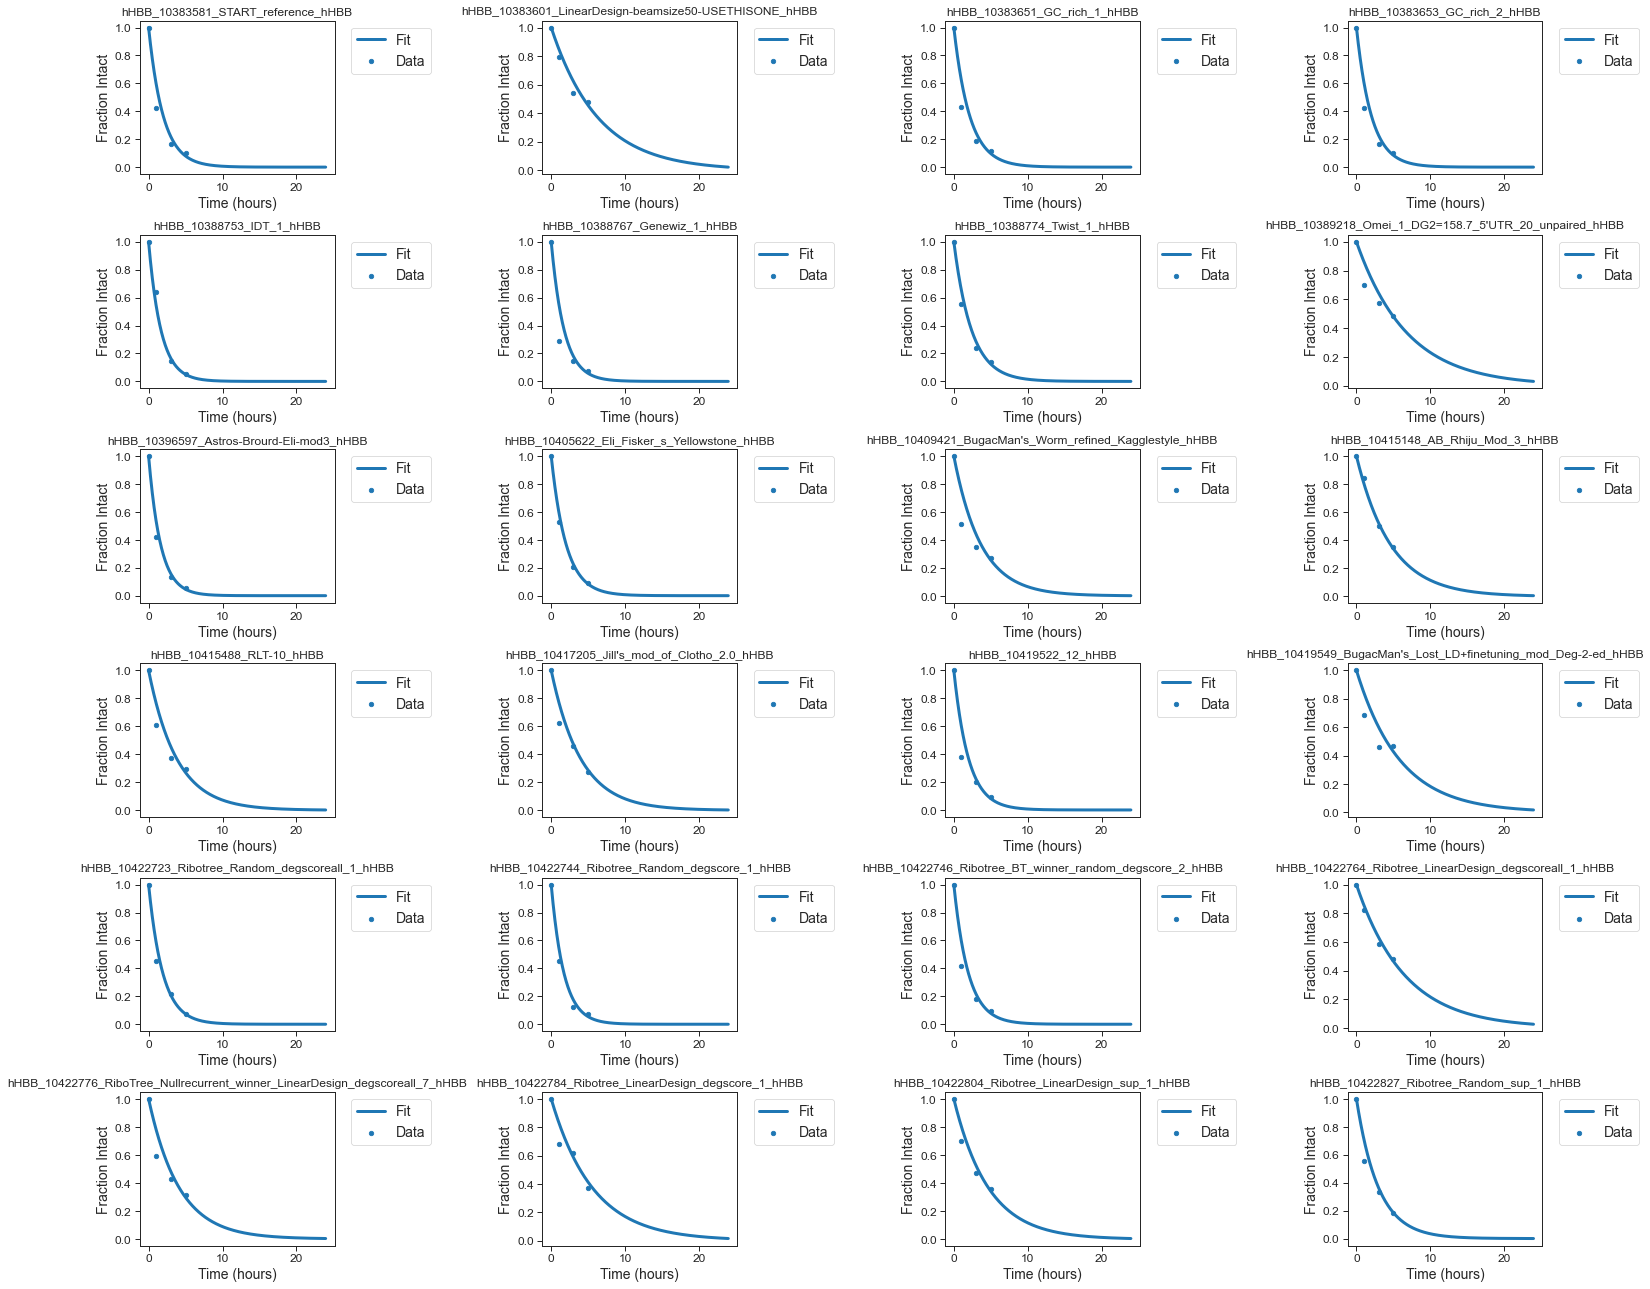

In [31]:
matplotlib.rcParams['pdf.fonttype'] = 42
plot_dir = './plots/'

#all combinations of sample and nucleotide type
samples = set(zip(map_df['Sample'], map_df['Nucleotide']))
# samples=samples[0]

sample_dfs = []
sample_fits = {}
all_fits = {}

num_plots = len(samples)
num_rows = round(num_plots/4, 1)
num_columns = num_plots/num_rows
figure(figsize=(num_rows*3+5, num_columns*4+2))

for i , sample in enumerate(sorted(samples)):
    
    subplot(num_rows, num_columns, i+1)
    
    rna_sample = sample[0]
    nucleotide = sample[1]

    working_df = map_df[(map_df['Sample']==rna_sample) & (map_df['Nucleotide']==nucleotide)]
#     working_df
    
#     norm_areas = np.array(working_df['normalized_area'])
    norm_areas = np.array(working_df['double_normalized'])
    times = np.array(working_df['Timepoint'])
    
    frac_intact = calc_frac_intact(times, norm_areas)
    working_df['Frac_Intact'] = frac_intact
    
    scatter(times, frac_intact, label='Data', s=20, marker='o')
    
#     plot(times, frac_intact, label=sample, linewidth=3)
    
    fit_dict = {}
    
    try:
        print('Trying an exponential fit...'+str(sample))
        fits = np.array(log_transform_fit(timepoints = times, frac_intact=frac_intact, bs_iter=1000))
#         fits = exp_fit(timepoints=times, frac_intact=frac_intact, func=func)
        kdeg = np.mean(fits)
        kdeg_err = np.std(fits)
        print(kdeg)
        print(kdeg_err)
        fit_dict['kdeg'] = kdeg
        fit_dict['kdeg_err'] = kdeg_err
        
        plot(np.arange(0,24,0.05), frac_intact[0]*np.exp(-1*kdeg*np.arange(0,24,0.05)), linewidth=3, label='Fit')

    except RuntimeError:
        print('Could not converge for...'+str(sample))
        fit_dict['kdeg'] = 'Error'
        fit_dict['kdeg_err'] = 'Error'
        continue
    
    sample_fits[sample] = fit_dict
    all_fits[sample] = fits


    legend(loc='upper left', bbox_to_anchor=(1.05,1), fontsize=14)
    title('{}'.format(rna_sample), fontsize=12)
    xlabel('Time (hours)')
    ylabel('Fraction Intact')
    tight_layout()

savefig(plot_dir+'12-02_numpy_exponential_fit.pdf')
#     clf()
tight_layout()

In [32]:
fit_df = pd.DataFrame.from_dict(sample_fits, orient='index')
fit_df.to_csv('12-02-2020_numpy_exponential_fits.csv')

In [26]:
init_areas = {}
for sample in samples:
    sample_name = sample[0]
    sample_nt = sample[1]
    init_areas[sample] = float(map_df[(map_df['Timepoint']==0)&(map_df['Sample']==sample_name)
                               &(map_df['Nucleotide']==sample_nt)]['double_normalized'])

frac_intact_list = []
for row in map_df.itertuples():
    sample_nt = (row.Sample, row.Nucleotide)
    frac_intact = row.double_normalized/init_areas[sample_nt]
    frac_intact_list.append(frac_intact)

map_df['Fraction_intact'] = frac_intact_list

map_df.to_csv('12-02-2020_fraction_intact.csv')

### normaling each lane by how much degradation product exists aka % intact per lane

In [13]:
from tqdm import tqdm

### TO DO:
- normalize per lane, based on how much degradation product in each lane
- for each lane, normalize intensity by what % of product is desired band
- then divide % full length product by the % at 0 hrs (should be ~1) to get fraction intact over time
- at the end, print scatterplot of fraction intact over time, and then the exponential fit (average from bootstrap method)


In [18]:
lane_df = map_df

for row in tqdm(lane_df.itertuples()):
    sample_df = pd.read_csv(data_dir+row.FileName)

    #clipping length to only relavent nucleotides
    array_len = len(sample_df['Nucleotides'])
    clip_len = int(array_len/2.2)
    
    #nucleotides and signal, don't subtract background but let's 
    #keep around just in case
    nts = np.array(sample_df['Nucleotides'][:clip_len])
    trace = np.array(sample_df['Value'][:clip_len])
    
    ###background subtracted trace
    trace_norm,_ = baseline_xi(trace)
    
    #for each sample, determine where the peaks occur
    #should think about messing around with start_nt and end_nt values (+/- 100)
    if (row.Timepoint == 0):
        peak_idx, peak_val = find_trace_peaks(trace,min_distance=100, min_height=1)
        peak_nts = nts[peak_idx]
        peak_nts_list.append(peak_nts)
        
        start_nt = nts[peak_idx][-1]-100
        end_nt = nts[peak_idx][-1]+100
        
        start_nt_list.append(start_nt)
        end_nt_list.append(end_nt)
        
        peak_assign_dict = {}
        peak_assign_dict['start_nt'] = start_nt
        peak_assign_dict['end_nt'] = end_nt
        peak_assign_dict['peaks'] = peak_nts
        
        peaks_nt_dict[(row.Sample, row.Nucleotide)] = peak_assign_dict

    else:
        time_0_dict = peaks_nt_dict[(row.Sample, row.Nucleotide)]
        peak_nts_list.append(time_0_dict['peaks'])
        start_nt_list.append(time_0_dict['start_nt'])
        end_nt_list.append(time_0_dict['end_nt'])
        
        start_nt = time_0_dict['start_nt']
        end_nt = time_0_dict['end_nt']
    
    #calculating the areas for the peaks--this is where I need to tweak
    p4p6, background, total, subtract, normalized = return_peak_areas(start_nt, end_nt, trace, nts)
    
    #need to also calculate the area of the entire trace between nucleotides: ~150-end_nt
    p4p6_area_list.append(p4p6)
    bg_area_list.append(background)
    total_area_list.append(total)
    subtract_area_list.append(subtract)
    normalized_area_list.append(normalized)

96it [00:01, 74.84it/s]


In [25]:
lane_df.head(5)

,Sample,Nucleotide,Timepoint,Plate,FileNumber,Unnamed: 5,Unnamed: 6,Unnamed: 7,FileName,peak_nts,start_nt,end_nt,p4p6_area,background_area,total_area,subtracted_area,normalized_area,double_normalized
0,hHBB_10383581_START_reference_hHBB,PSU,0,1,1,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 282.58199461952114, 857.84...",757.844023,957.844023,172.831666,265.032756,2590.010892,2324.978137,13.452269,0.135416
1,hHBB_10383581_START_reference_hHBB,PSU,1,1,2,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 282.58199461952114, 857.84...",757.844023,957.844023,219.463144,373.637585,1630.613554,1256.975969,5.727504,0.057399
2,hHBB_10383581_START_reference_hHBB,PSU,3,1,3,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 282.58199461952114, 857.84...",757.844023,957.844023,283.585564,318.585421,916.412868,597.827447,2.108103,0.022492
3,hHBB_10383581_START_reference_hHBB,PSU,5,1,4,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 282.58199461952114, 857.84...",757.844023,957.844023,290.817522,274.841358,646.567451,371.726093,1.278211,0.013427
4,hHBB_10383601_LinearDesign-beamsize50-USETHISO...,PSU,0,1,5,NaN,NaN,NaN,nts-Eukaryote Total RNA Nano_2020-12-02_14-31-...,"[23.34814491209477, 279.6929620324952, 870.832...",770.832303,970.832303,188.141484,226.492036,1684.142831,1457.650795,7.747631,0.078140


### comparing natural RNAs only
#### barplot, fraction intact over 4 time points

In [27]:
# map_df

plot_data = map_df[map_df['Nucleotide']=='natural'].sort_values(by='Sample', ascending=False)

figure(figsize=(10,5))
sns.barplot(data=plot_data, x='Sample',y='Fraction_intact', hue='Timepoint',
           palette='Greys_r')

legend(title='Hours', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
title('Natural nucleotide, Fraction intact over time')
xlabel('RNA')
ylabel('Fraction Intact')
xticks(rotation=45, ha='right')

tight_layout()
savefig(plot_dir+'barplot_FracInt_time_naturalRNA.png', dpi=300)

<Figure size 720x360 with 0 Axes>

ValueError: min() arg is an empty sequence

<Figure size 720x360 with 0 Axes>

### comparing natural to modified nucleotides

<Figure size 720x1800 with 0 Axes>

Text(0.5, 1.0, 'Fraction Intact at 1 Hr, U vs. PSU')

Text(0.5, 0, '')

Text(0, 0.5, 'Fraction Intact')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

Text(0.5, 1.0, 'Fraction Intact at 3 Hr, U vs. PSU')

Text(0.5, 0, '')

Text(0, 0.5, 'Fraction Intact')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

Text(0.5, 1.0, 'Fraction Intact at 5 Hr, U vs. PSU')

Text(0.5, 0, 'RNA')

Text(0, 0.5, 'Fraction Intact')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

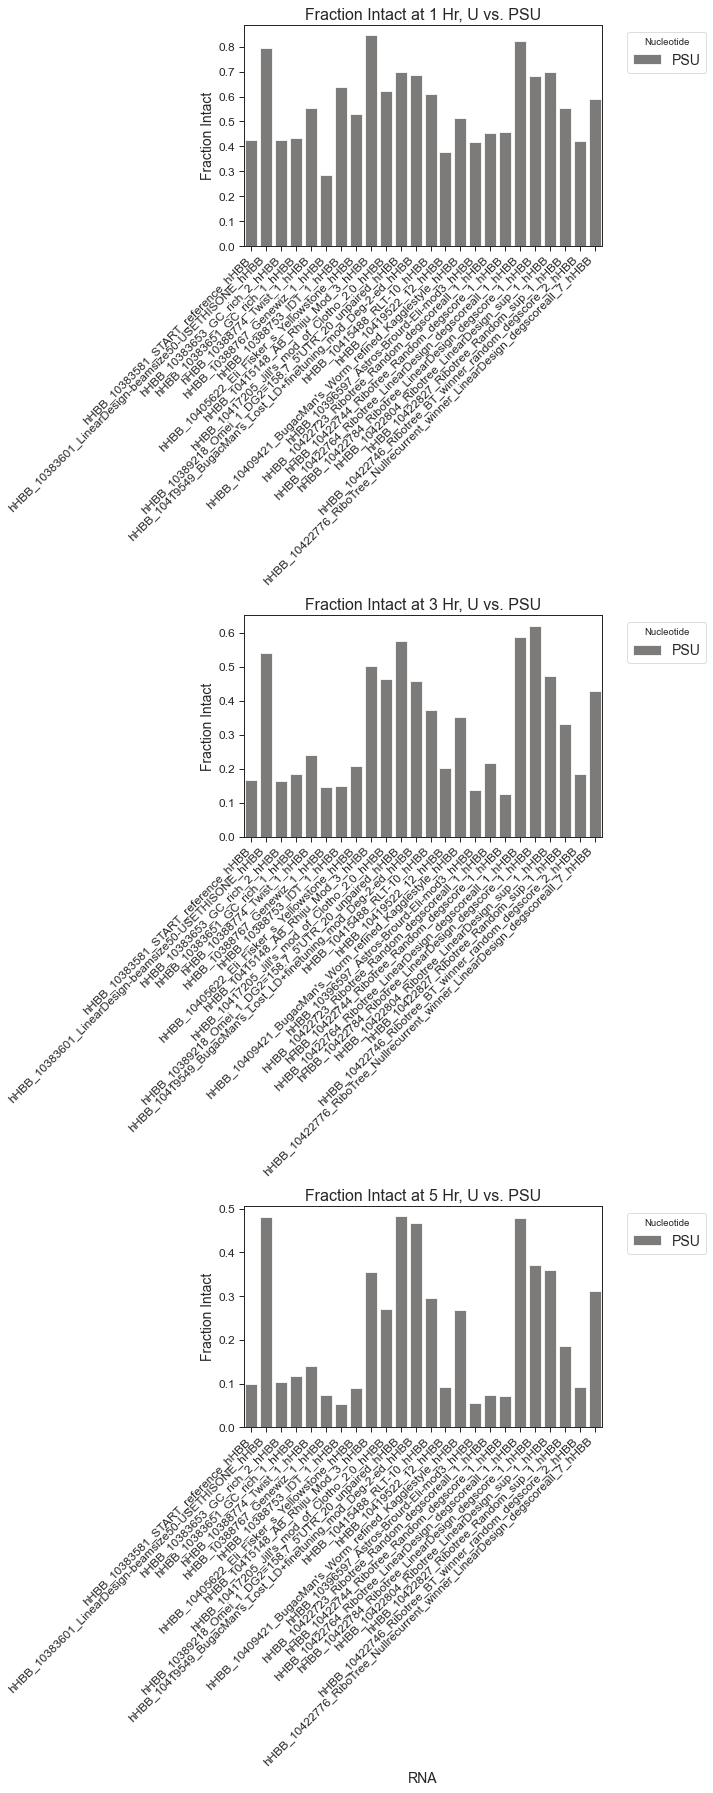

In [33]:
### let's take timepoint 2 (1 hr) as a benchmark, and also compare fraction intact at 5 hours
mod_samples = list(map_df[map_df['Nucleotide']=='PSU']['Sample'])

times = [1, 3, 5]

nrows = 3
ncolumns = 1

figure(figsize=(10,25))

for i, time in enumerate(times):
    subplot(nrows,ncolumns,i+1)
    
    plot_data = map_df[(map_df['Sample'].isin(mod_samples)) & (map_df['Timepoint']==time)]
    
    sns.barplot(data=plot_data, x='Sample',y='Fraction_intact', hue='Nucleotide',
               palette='cividis')

    legend(title='Nucleotide', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
    title('Fraction Intact at '+str(time)+' Hr, U vs. PSU')
    
    if i==2:
        xlabel('RNA')
    else:
        xlabel('')
    ylabel('Fraction Intact')
    xticks(rotation=45, ha='right')

    tight_layout()
savefig(plot_dir+'barplot_FracInt_times_PSU.png', dpi=300)

<Figure size 1440x2160 with 0 Axes>

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 <a list of 24 Text major ticklabel objects>)

Text(157.65312499999996, 0.5, '')

Text(0.5, 247.7, 'Hours')

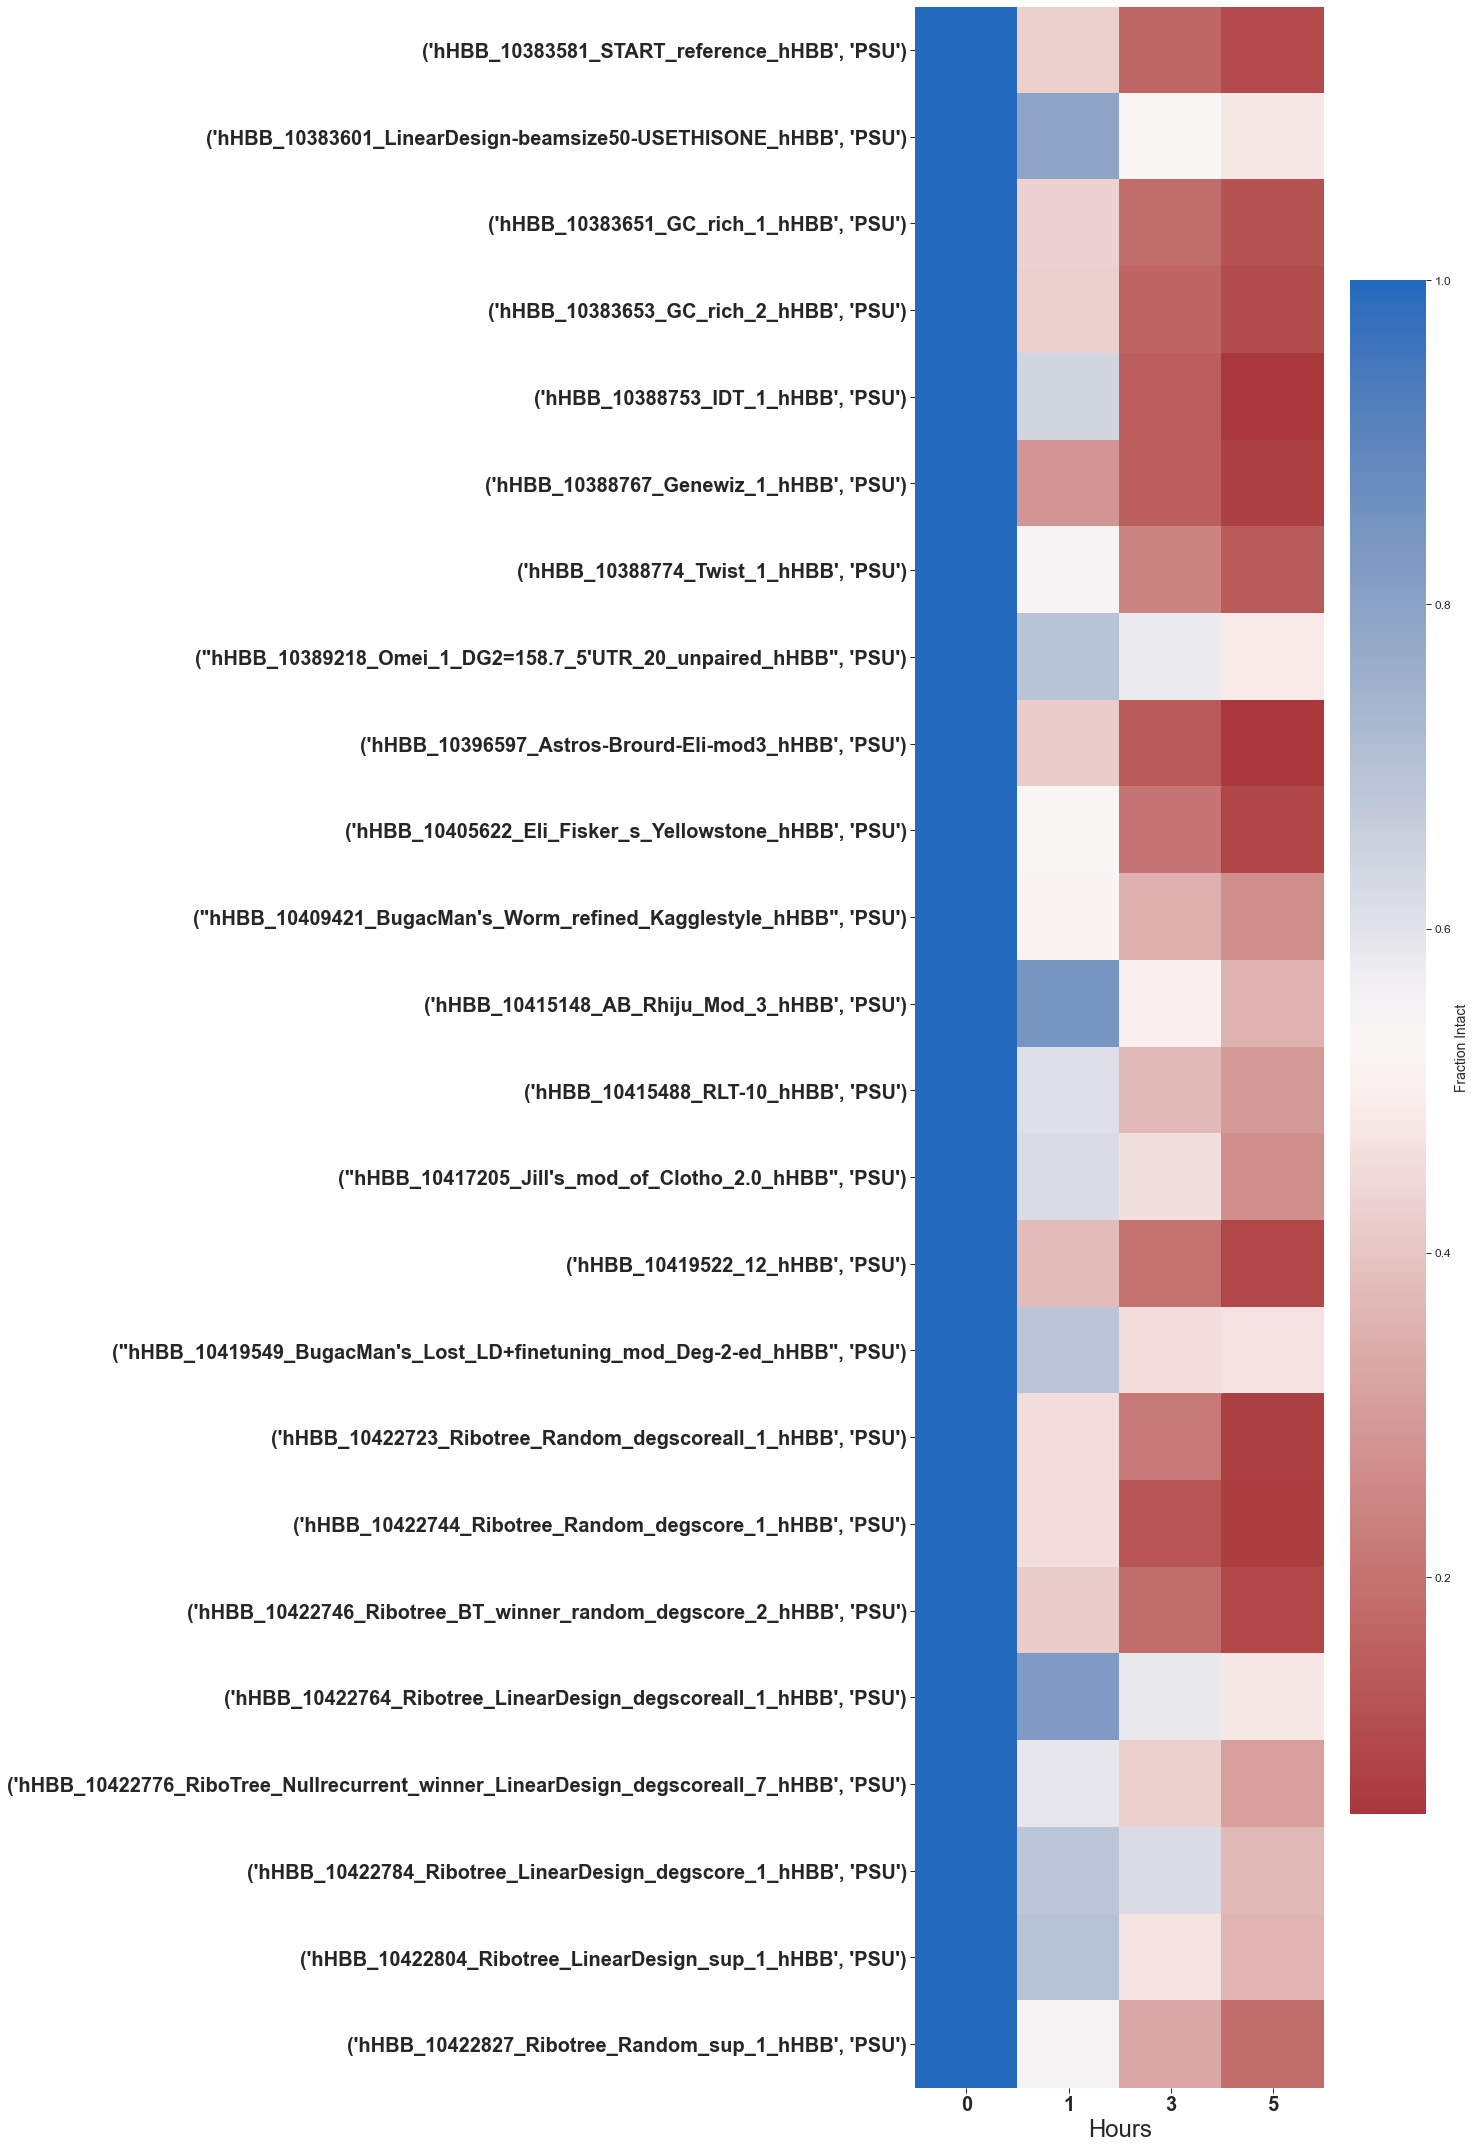

In [30]:
map_df['sample_nt'] = list(zip(map_df['Sample'], map_df['Nucleotide']))
melted_df = map_df.pivot(index='sample_nt', columns='Timepoint', values='Fraction_intact')
# melted_df

figure(figsize=(20,30))
sns.heatmap(data=melted_df, cmap='vlag_r',cbar_kws={'label': 'Fraction Intact'})
xticks(fontsize=20, fontweight='bold')
yticks(fontsize=20, fontweight='bold')
ylabel('')
xlabel('Hours', fontsize=24)
tight_layout()
# title('Fraction Intact over time', fontsize=30)

savefig(plot_dir+'heatmap_fracintact.png', dpi=300)

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'RNA')

Text(0, 0.5, 'kdeg (hr-1)')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

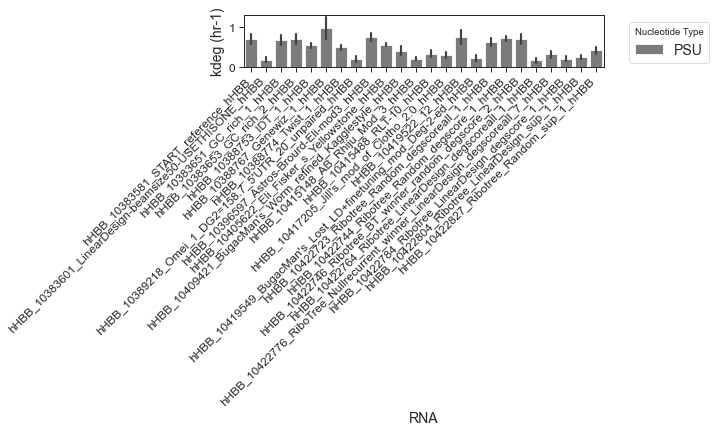

In [32]:
all_fits_df = pd.DataFrame.from_dict(all_fits, orient='index')
all_fits_df = all_fits_df.reset_index().rename({'index':'Sample'})
all_fits_df_long = pd.melt(all_fits_df, id_vars=['index'], value_vars=np.arange(1000))
all_fits_df_long['Sample'] = [str(sample[0]) for sample in all_fits_df_long['index']]
all_fits_df_long['Nucleotide'] = [str(sample[1]) for sample in all_fits_df_long['index']]
all_fits_df_long['kdeg'] = [float(x) for x in all_fits_df_long['value']]

kdeg_df_long = all_fits_df_long[['Sample', 'Nucleotide', 'kdeg']]


figure(figsize=(10,6))
sns.barplot(data=kdeg_df_long, x='Sample', y='kdeg', hue='Nucleotide', ci='sd', palette='cividis')
xlabel('RNA')
ylabel('kdeg (hr-1)')
legend(title='Nucleotide Type',loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
xticks(ha='right', rotation=45)
tight_layout()
savefig(plot_dir+'kdeg_fits.png', dpi=300)


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'RNA')

Text(0, 0.5, 'kdeg (hr-1)')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

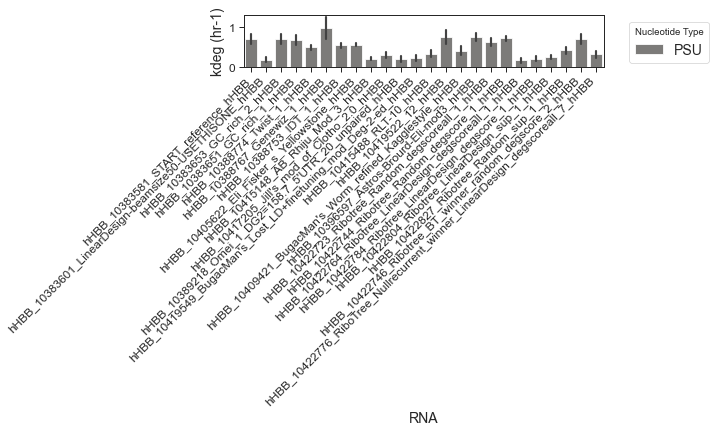

In [45]:
# kdeg_df_long

seqid_names = pd.read_csv('seqid_names.csv')
seqid_names_dict = dict(zip(seqid_names['Human readable name'], seqid_names['Barcode']))
# seqid_names_dict

seqid_list = []
for row in kdeg_df_long.itertuples():
    seqid_list.append(seqid_names_dict[row.Sample])
    
kdeg_df_long['seqid'] = seqid_list

# kdeg_df_long

figure(figsize=(10,6))
sns.barplot(data=kdeg_df_long.sort_values(by='seqid', ascending=True), x='Sample', y='kdeg', hue='Nucleotide', ci='sd', palette='cividis')
xlabel('RNA')
ylabel('kdeg (hr-1)')
legend(title='Nucleotide Type',loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
xticks(ha='right', rotation=45)
tight_layout()
savefig(plot_dir+'kdeg_fits_ordered_seqid.png', dpi=300)


### flexible peak identification

In [ ]:
# peak_nts_list = []
# start_nt_list = []
# end_nt_list = []
# p4p6_area_list = []
# bg_area_list = []
# total_area_list = []
# subtract_area_list = []
# normalized_area_list = []
# signal_normalized_area_list = []

# plot_dir = './plots/'

peaks_nt_dict = {}
# Iterate through the list of samples, and return a df that has nucleotides and background subtracted values
for row in map_df.itertuples():
    clf()
    #read in dataframe for given sample
    sample_df = pd.read_csv(data_dir+row.FileName)
    
    #extract time series and nucleotides, let's clip to just the first third (up to ~1400 nucleotides)
    array_len = len(sample_df['Nucleotides'])
    clip_len = int(array_len/2.2)
    
    nts = np.array(sample_df['Nucleotides'][:clip_len])
    trace = np.array(sample_df['Value'][:clip_len])
    
#     if (row.Timepoint == 0):
    peak_idx, peak_val = find_trace_peaks(trace,min_distance=100, min_height=1)
    peak_nts = nts[peak_idx]
    peak_nts_list.append(peak_nts)

    start_nt = nts[peak_idx][-1]-100
    end_nt = nts[peak_idx][-1]+100

    start_nt_list.append(start_nt)
    end_nt_list.append(end_nt)

    peak_assign_dict = {}
    peak_assign_dict['start_nt'] = start_nt
    peak_assign_dict['end_nt'] = end_nt
    peak_assign_dict['peaks'] = peak_nts

#     peaks_nt_dict[(row.Sample, row.Nucleotide)] = peak_assign_dict

#     else:
#         time_0_dict = peaks_nt_dict[(row.Sample, row.Nucleotide)]
#         peak_nts_list.append(time_0_dict['peaks'])
#         start_nt_list.append(time_0_dict['start_nt'])
#         end_nt_list.append(time_0_dict['end_nt'])

#         start_nt = time_0_dict['start_nt']
#         end_nt = time_0_dict['end_nt']

#     #integrate at specified nucleotides per sample
#     start_nt = nts[peak_idx][-1]-100
#     end_nt = nts[peak_idx][-1]+100
#     start_nt_list.append(start_nt)
#     end_nt_list.append(end_nt)
    
    p4p6, background, total, subtract, normalized = return_peak_areas(start_nt, end_nt, trace, nts)
    p4p6_area_list.append(p4p6)
    bg_area_list.append(background)
    total_area_list.append(total)
    subtract_area_list.append(subtract)
    normalized_area_list.append(normalized)
    
    _,_,control_area_25, _, _ = return_peak_areas(start_nt=5, end_nt = 50, trace=trace, trace_nt=nts)
    double_normalized = normalized/control_area_25
    signal_normalized_area_list.append(double_normalized)

map_df = map_df.assign(peak_nts = peak_nts_list, start_nt = start_nt_list, end_nt = end_nt_list,\
              p4p6_area = p4p6_area_list, background_area = bg_area_list, total_area = total_area_list,\
              subtracted_area = subtract_area_list, normalized_area = normalized_area_list, double_normalized = signal_normalized_area_list)

map_df
#export dataframe to .csv for recordkeeping
map_df.to_csv('12-02-2020_analyzed_samples_doublenormalized.csv')

#plot configuration
# title('Background Subtracted Traces')
# xlabel('Nucleotides')
# ylabel('Signal (FU)')
# tight_layout()
# savefig('10-21-2020_traces.png', dpi=300)